# NLP Lab 3: Word Embeddings

**Mục tiêu:** Tìm hiểu và ứng dụng Word Embeddings để biểu diễn từ dưới dạng dense vectors.

**Nội dung:**
1. Task 1: Tải và sử dụng model pre-trained (GloVe)
2. Task 2: Nhúng văn bản (Document Embedding)
3. Task 3: Huấn luyện Word2Vec trên dữ liệu nhỏ (Gensim)
4. Task 4: Huấn luyện Word2Vec trên dữ liệu lớn (Spark)
5. Task 5: Trực quan hóa Embedding với t-SNE

In [1]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

from representations.word_embedder import WordEmbedder

## Task 1: Tải và sử dụng model pre-trained (GloVe)

Sử dụng model `glove-wiki-gigaword-50` (50 chiều, huấn luyện trên Wikipedia).

In [2]:
# Khởi tạo WordEmbedder
embedder = WordEmbedder('glove-wiki-gigaword-50')

Đang tải model 'glove-wiki-gigaword-50'... Vui lòng chờ.
Đang load ../data/glove.6B.50d.txt...
Tải model thành công.


In [3]:
# 1. Lấy vector cho từ 'king'
king_vector = embedder.get_vector('king')
print(f"Vector của 'king' (5 phần tử đầu): {king_vector[:5]}")
print(f"Kích thước vector: {len(king_vector)}")

Vector của 'king' (5 phần tử đầu): [ 0.50451   0.68607  -0.59517  -0.022801  0.60046 ]
Kích thước vector: 50


In [4]:
# 2. Tính độ tương đồng
sim_king_queen = embedder.get_similarity('king', 'queen')
sim_king_man = embedder.get_similarity('king', 'man')

print(f"Độ tương đồng 'king' - 'queen': {sim_king_queen:.4f}")
print(f"Độ tương đồng 'king' - 'man': {sim_king_man:.4f}")

Độ tương đồng 'king' - 'queen': 0.7839
Độ tương đồng 'king' - 'man': 0.5309


In [5]:
# 3. Tìm 10 từ tương đồng nhất với 'computer'
similar_words = embedder.get_most_similar('computer', top_n=10)
print("10 từ tương đồng nhất với 'computer':")
for word, score in similar_words:
    print(f"  {word}: {score:.4f}")

10 từ tương đồng nhất với 'computer':
  computers: 0.9165
  software: 0.8815
  technology: 0.8526
  electronic: 0.8126
  internet: 0.8060
  computing: 0.8026
  devices: 0.8016
  digital: 0.7992
  applications: 0.7913
  pc: 0.7883


### Phân tích Task 1:
- **'king' vs 'queen'**: Độ tương đồng cao (~0.78) vì cùng trường ngữ nghĩa "hoàng gia"
- **'king' vs 'man'**: Thấp hơn (~0.53), thể hiện mối quan hệ giới tính
- **Từ đồng nghĩa 'computer'**: Các từ liên quan công nghệ (software, technology, internet...)

## Task 2: Nhúng văn bản (Document Embedding)

Tạo vector cho cả câu bằng cách lấy trung bình (mean pooling) các word vectors.

In [6]:
# Nhúng câu
sentence = "The queen rules the country."
sentence_vector = embedder.embed_document(sentence)

print(f"Câu: '{sentence}'")
print(f"Vector (5 phần tử đầu): {sentence_vector[:5]}")
print(f"Kích thước: {len(sentence_vector)}")

Câu: 'The queen rules the country.'
Vector (5 phần tử đầu): [ 0.02444201  0.378018   -0.638166    0.0128046   0.0524286 ]
Kích thước: 50


## Task 3: Huấn luyện Word2Vec trên dữ liệu nhỏ (Gensim)

Tự huấn luyện model Word2Vec trên toy corpus để so sánh với pre-trained model.

In [7]:
from gensim.models import Word2Vec

# Toy corpus
corpus = [
    "the king and queen ruled the kingdom",
    "the prince is the son of the king",
    "the princess is the daughter of the queen",
    "the man and woman walked in the park",
    "the boy played with his dog",
    "the girl played with her cat"
]
tokenized_corpus = [doc.split() for doc in corpus]

# Huấn luyện
small_model = Word2Vec(sentences=tokenized_corpus, vector_size=50, window=5, min_count=1, epochs=100)

# Lưu model
os.makedirs('results', exist_ok=True)
small_model.save('results/word2vec_small.model')
print("Model saved to results/word2vec_small.model")

Model saved to results/word2vec_small.model


In [8]:
# Đánh giá model tự huấn luyện
print("--- Model tự huấn luyện ---")
print(f"Similarity 'king'-'queen': {small_model.wv.similarity('king', 'queen'):.4f}")
print(f"Most similar to 'king': {small_model.wv.most_similar('king', topn=5)}")

print("\n--- Model pre-trained (GloVe) ---")
print(f"Similarity 'king'-'queen': {embedder.get_similarity('king', 'queen'):.4f}")

--- Model tự huấn luyện ---
Similarity 'king'-'queen': 0.0560
Most similar to 'king': [('cat', 0.20858465135097504), ('woman', 0.19271892309188843), ('the', 0.19120626151561737), ('prince', 0.18093883991241455), ('is', 0.15204031765460968)]

--- Model pre-trained (GloVe) ---
Similarity 'king'-'queen': 0.7839


### So sánh model pre-trained vs tự huấn luyện:
- **Model tự huấn luyện**: Kết quả kém do thiếu dữ liệu, không phản ánh đúng ngữ nghĩa
- **Model pre-trained**: Học từ hàng tỷ từ, nắm bắt mối quan hệ ngữ nghĩa tốt hơn nhiều
- **Kết luận**: Sử dụng pre-trained models tiết kiệm tài nguyên và cho kết quả tốt hơn

## Task 4: Huấn luyện Word2Vec trên dữ liệu lớn (Apache Spark)

Minh họa quy trình huấn luyện Word2Vec với Spark MLlib cho Big Data.

In [9]:
import warnings
import os

# Tắt Python warnings
warnings.filterwarnings('ignore')

# Tắt Java/Spark warnings
os.environ['PYSPARK_SUBMIT_ARGS'] = '--conf spark.driver.extraJavaOptions="-Xlog:disable" pyspark-shell'

from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, Word2Vec
from pyspark.sql.functions import col, lower, regexp_replace

# Khởi tạo Spark
spark = SparkSession.builder.appName("Word2VecDemo").getOrCreate()

data = [
    ("Apache Spark is a unified analytics engine for large-scale data processing.",),
    ("Word2Vec is a natural language processing algorithm.",),
    ("The computer processes data quickly using its powerful processor.",)
]
df = spark.createDataFrame(data, ["text"])

# Tiền xử lý
df = df.withColumn("text", lower(col("text")))
df = df.withColumn("text", regexp_replace(col("text"), "[^a-z\\s]", ""))

tokenizer = Tokenizer(inputCol="text", outputCol="words")
df = tokenizer.transform(df)

# Huấn luyện Word2Vec
word2vec = Word2Vec(vectorSize=100, minCount=1, inputCol="words", outputCol="result")
model = word2vec.fit(df)

# Tìm từ đồng nghĩa
print("5 từ đồng nghĩa với 'data':")
model.findSynonyms("data", 5).show()

spark.stop()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/17 20:52:08 WARN Utils: Your hostname, pearles-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.101 instead (on interface en0)
25/12/17 20:52:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/17 20:52:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/17 20:52:10 WARN FileSystem: Cannot load filesystem
java.util.ServiceConfigurationError: org.apache.hadoop.fs.FileSystem: Provider org.apache.hadoop.fs.viewfs.ViewFileSystem could not be instantiated
	at java.base/java.util.ServiceLoader.fail(ServiceLoader.java:552)
	at java.base/java.util.ServiceLoader$Prov

5 từ đồng nghĩa với 'data':
+--------+--------------------+
|    word|          similarity|
+--------+--------------------+
|  engine|   0.123680479824543|
|powerful| 0.08107161521911621|
|   spark| 0.06511847674846649|
| quickly|  0.0441107302904129|
| unified|0.041998762637376785|
+--------+--------------------+



## Task 5: Trực quan hóa Embedding với t-SNE

Giảm chiều word vectors xuống 2D để quan sát các cụm ngữ nghĩa.

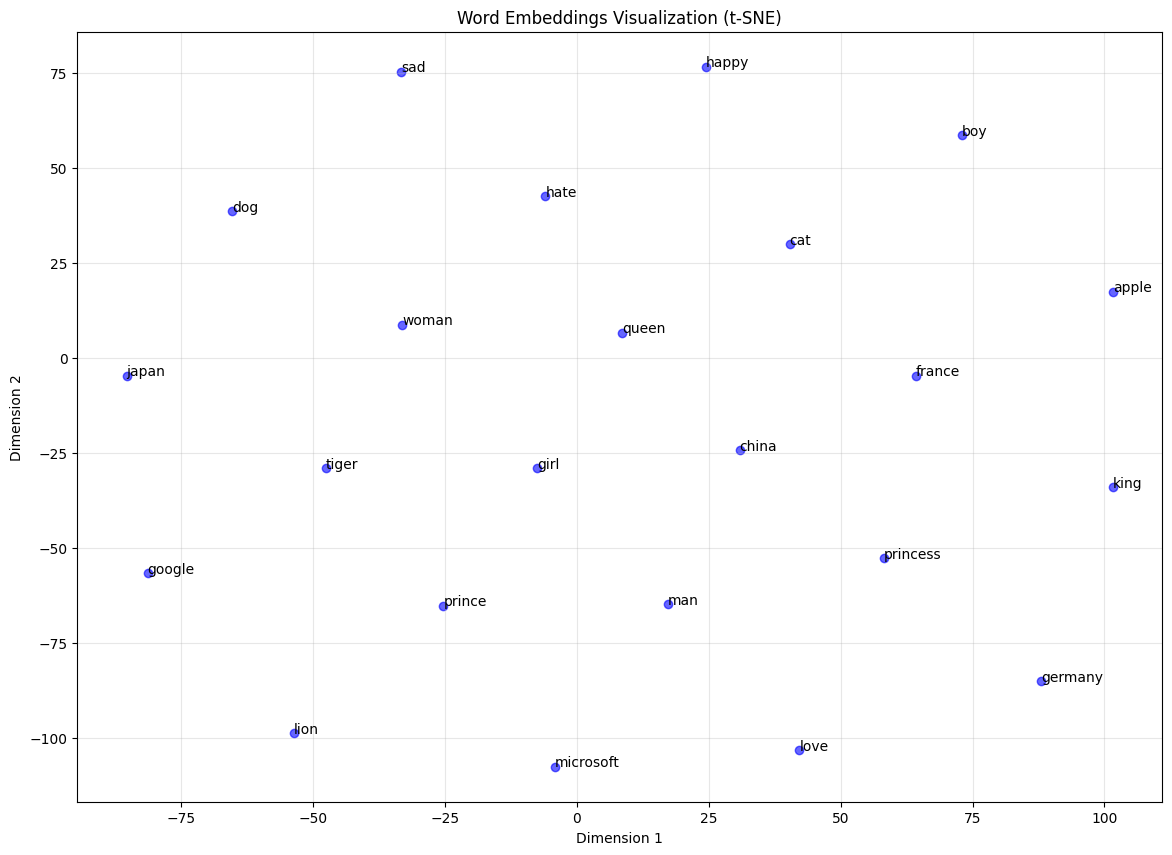

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Danh sách từ theo nhóm ngữ nghĩa
words = [
    'king', 'queen', 'prince', 'princess',  # Hoàng gia
    'man', 'woman', 'boy', 'girl',          # Con người
    'cat', 'dog', 'lion', 'tiger',          # Động vật
    'france', 'germany', 'china', 'japan',  # Quốc gia
    'apple', 'google', 'microsoft',         # Công ty
    'love', 'hate', 'happy', 'sad'          # Cảm xúc
]

# Lấy vectors
vectors = np.array([embedder.get_vector(w) for w in words])

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(len(words)-1, 30))
vectors_2d = tsne.fit_transform(vectors)

# Plot
plt.figure(figsize=(14, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='blue', alpha=0.6)
for i, word in enumerate(words):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=10)
plt.title("Word Embeddings Visualization (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True, alpha=0.3)
plt.show()

### Phân tích biểu đồ:
- **Các cụm rõ rệt**: Từ cùng trường ngữ nghĩa nhóm lại gần nhau
  - Hoàng gia: king, queen, prince, princess
  - Quốc gia: france, germany, china, japan
  - Công ty: apple, google, microsoft
- **Giải thích**: Trong dữ liệu huấn luyện (Wikipedia), các từ cùng nhóm xuất hiện trong ngữ cảnh tương tự → vectors gần nhau